In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
from scipy.stats import t, ttest_ind, bootstrap

# Задание 1

In [18]:
reg_data = pd.read_csv('problem1-reg_data.csv',sep=';')
auth_data = pd.read_csv('problem1-auth_data.csv',sep=';')

In [21]:
def calculate_retention(reg_data, auth_data, max_days=14,min_date=None):
    # Преобразуем timestamp в дату
    reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.normalize()
    auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.normalize()
    
    # Фильтруем только нужный период
    if min_date:
        reg_data= reg_data[reg_data['reg_date'] >= pd.to_datetime(min_date)]
        
    # Объединяем сессии с датой регистрации
    merged = auth_data.merge(reg_data[['uid', 'reg_date']], on='uid')
    merged['n_days'] = (merged['auth_date'] - merged['reg_date']).dt.days
    
    # Оставляем только нужные дни
    merged = merged[(merged['n_days'] >= 0) & (merged['n_days'] <= max_days)]
    
    # Размер когорты (сколько пользователей зарегистрировалось в каждый день)
    cohort_sizes = reg_data.groupby('reg_date')['uid'].nunique()
    
    # Сколько уникальных пользователей из когорты вернулось в каждый день
    retention_counts = (
        merged.groupby(['reg_date', 'n_days'])['uid']
        .nunique()
        .reset_index()
    )
    
    # Собираем retention-матрицу
    retention_matrix = retention_counts.pivot(index='reg_date', columns='n_days', values='uid')
    retention_matrix = retention_matrix.divide(cohort_sizes, axis=0).fillna(0)
    retention_matrix.columns = [f'D{col}' for col in retention_matrix.columns]
    return retention_matrix

# Пример использования:
retention = calculate_retention(reg_data, auth_data, max_days=14, min_date='2019-09-01')
retention

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
reg_date,,,,,,,,,,,,,,,
2019-09-01,1.0,0.017261,0.050633,0.048331,0.044879,0.069045,0.077100,0.067894,0.054085,0.067894,0.057537,0.054085,0.054085,0.064442,0.050633
2019-09-02,1.0,0.016092,0.037931,0.042529,0.051724,0.056322,0.064368,0.055172,0.043678,0.065517,0.045977,0.064368,0.041379,0.052874,0.028736
2019-09-03,1.0,0.024110,0.030999,0.050517,0.059701,0.052813,0.068886,0.052813,0.045924,0.049369,0.050517,0.060850,0.043628,0.047072,0.048220
2019-09-04,1.0,0.008018,0.034364,0.048110,0.043528,0.059565,0.074456,0.065292,0.051546,0.038946,0.056128,0.044674,0.045819,0.052692,0.058419
2019-09-05,1.0,0.019451,0.038902,0.046911,0.051487,0.056064,0.069794,0.069794,0.040046,0.058352,0.035469,0.050343,0.051487,0.042334,0.049199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-19,1.0,0.018360,0.035496,0.047124,0.034884,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-09-20,1.0,0.024450,0.043399,0.023839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-09-21,1.0,0.018926,0.029915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


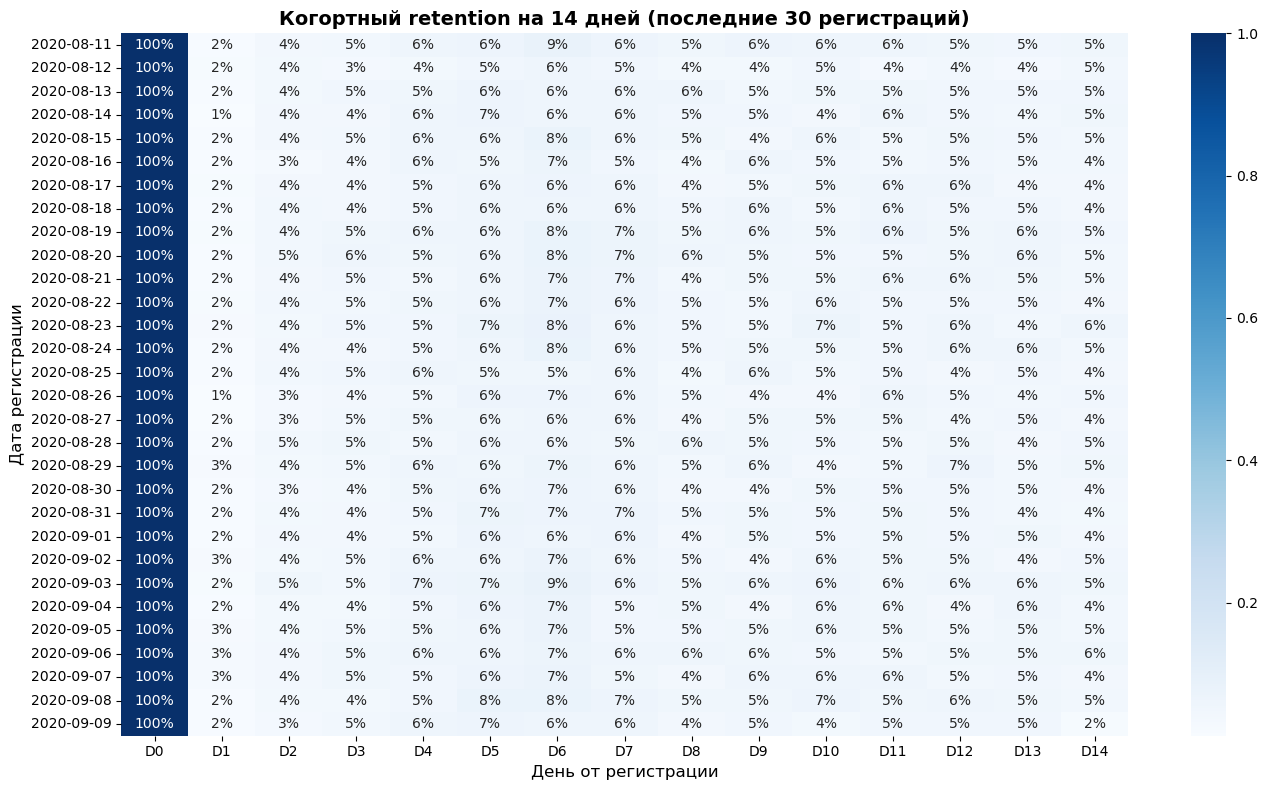

In [4]:
# Определяем последнюю возможную дату, когда когорта могла зарегистрироваться
# чтобы успеть накопить все 14 дней ретеншна
latest_full_cohort = retention.index.max() - pd.Timedelta(days=14)

# Фильтруем retention: берём когорты до этой даты
filtered_retention = retention[retention.index <= latest_full_cohort]

# Теперь берём последние 30 «полных» когорт
filtered_retention = filtered_retention.iloc[-30:]

filtered_retention.index = filtered_retention.index.strftime('%Y-%m-%d')

plt.figure(figsize=(14, 8))
sns.heatmap(
    filtered_retention,  # последние 30 когорт
    cmap="Blues",
    annot=True,
    annot_kws={"size": 10},
    fmt='.0%',
    cbar=True
)
plt.title('Когортный retention на 14 дней (последние 30 регистраций)', fontsize=14, weight='bold')
plt.xlabel('День от регистрации', fontsize=12)
plt.ylabel('Дата регистрации', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Задание 2

In [5]:
CSV_PATH = "project_1_task_2.csv"
USE_BOOTSTRAP = True               
N_RESAMPLES = 100         

In [6]:
def welch_ci_diff_means(x_b, x_a, alpha=0.05):
    """
    95% ДИ для разницы средних (B - A) по Welch.
    """
    x_b = np.asarray(x_b, float)
    x_a = np.asarray(x_a, float)
    n_b, n_a = len(x_b), len(x_a)

    mb, ma = x_b.mean(), x_a.mean()
    vb, va = x_b.var(ddof=1), x_a.var(ddof=1)
    diff = mb - ma

    se = np.sqrt(vb/n_b + va/n_a)
    # Welch–Satterthwaite df
    df = (vb/n_b + va/n_a)**2 / ((vb**2)/((n_b**2)*(n_b-1)) + (va**2)/((n_a**2)*(n_a-1)))
    tcrit = t.ppf(1 - alpha/2, df)

    lo = diff - tcrit*se
    hi = diff + tcrit*se
    return float(lo), float(hi)

def bootstrap_ci_diff_means(x_b, x_a, n_resamples=100, alpha=0.05, seed=42):
    """
    95% ДИ разницы средних (B - A) через bootstrap
    """
    res = bootstrap(
        (np.asarray(x_b, float), np.asarray(x_a, float)),
        statistic=lambda b, a: np.mean(b) - np.mean(a),
        vectorized=False,
        paired=False,
        confidence_level=1 - alpha,
        n_resamples=n_resamples,
        method='percentile',
        random_state=seed
    )
    return float(res.confidence_interval.low), float(res.confidence_interval.high)

def fmt_pct(x, d=2): return f"{x*100:.{d}f}%"
def fmt_money(x, d=2): return f"{x:.{d}f}"
def fmt_pp(diff, d=2): return f"{(diff)*100:.{d}f} п.п."

In [23]:
task2 = pd.read_csv(CSV_PATH, sep=';')

In [25]:
# Нормализация значений
task2['testgroup'] = task2['testgroup'].astype(str).str.lower().str.strip()
task2['revenue'] = pd.to_numeric(task2['revenue'], errors='coerce').fillna(0)
task2['is_payer'] = task2['revenue'] > 0

In [9]:
# Метрики по группам
metrics = task2.groupby('testgroup').agg(
    total_users=('user_id', 'nunique'),
    paying_users=('is_payer', 'sum'),
    total_revenue=('revenue', 'sum')
).sort_index()

metrics['conversion_rate'] = metrics['paying_users'] / metrics['total_users']
metrics['arpu']  = metrics['total_revenue'] / metrics['total_users']
metrics['arppu'] = metrics.apply(
    lambda r: (r['total_revenue'] / r['paying_users']) if r['paying_users'] > 0 else np.nan, axis=1)

In [29]:
# Проверим 2 группы и зафиксируем порядок
groups = list(metrics.index)
if len(groups) != 2:
    raise ValueError(f"Ожидалось 2 группы, найдено: {groups}")
gA, gB = sorted(groups)

## Статистика

In [11]:
# 1) Z-тест разницы конверсий (CR)
count = [int(metrics.loc[gA, 'paying_users']), int(metrics.loc[gB, 'paying_users'])]
nobs  = [int(metrics.loc[gA, 'total_users']),  int(metrics.loc[gB, 'total_users'])]
zstat, p_cr = proportions_ztest(count, nobs, alternative='two-sided')

In [12]:
# 2) Welch t-тест для ARPU
a_rev = task2.loc[task2['testgroup'] == gA, 'revenue'].to_numpy()
b_rev = task2.loc[task2['testgroup'] == gB, 'revenue'].to_numpy()
tstat_arpu, p_arpu = ttest_ind(b_rev, a_rev, equal_var=False)

In [13]:
# 3) Доверительные интервалы разницы средних (B - A)
arpu_lo_welch, arpu_hi_welch = welch_ci_diff_means(b_rev, a_rev, alpha=0.05)

# Только среди платящих — ARPPU:
a_rev_pay = a_rev[a_rev > 0]
b_rev_pay = b_rev[b_rev > 0]
if len(a_rev_pay) > 1 and len(b_rev_pay) > 1:
    arppu_lo_welch, arppu_hi_welch = welch_ci_diff_means(b_rev_pay, a_rev_pay, alpha=0.05)
else:
    arppu_lo_welch = arppu_hi_welch = np.nan
    
# Bootstrap CI
if USE_BOOTSTRAP:
    arpu_lo_boot, arpu_hi_boot = bootstrap_ci_diff_means(b_rev, a_rev, n_resamples=N_RESAMPLES, alpha=0.05, seed=42)
else:
    arpu_lo_boot = arpu_hi_boot = np.nan

In [14]:
# Числа для отчёта
cr_a, cr_b = metrics.loc[gA,'conversion_rate'], metrics.loc[gB,'conversion_rate']
arpu_a, arpu_b = metrics.loc[gA,'arpu'], metrics.loc[gB,'arpu']
arppu_a, arppu_b = metrics.loc[gA,'arppu'], metrics.loc[gB,'arppu']

cr_diff   = cr_b - cr_a
arpu_diff = arpu_b - arpu_a
arppu_diff = (arppu_b - arppu_a) if np.isfinite(arppu_b) and np.isfinite(arppu_a) else np.nan

uplift_cr    = (cr_b / cr_a - 1) * 100 if cr_a != 0 else np.nan
uplift_arpu  = (arpu_b / arpu_a - 1) * 100 if arpu_a != 0 else np.nan
uplift_arppu = (arppu_b / arppu_a - 1) * 100 if np.isfinite(arppu_b) and np.isfinite(arppu_a) and arppu_a != 0 else np.nan

In [15]:
# Отчет
lines = []
lines.append("ОТЧЁТ ПО РЕЗУЛЬТАТАМ A/B-ТЕСТА АКЦИОННЫХ ПРЕДЛОЖЕНИЙ\n")
lines.append("Цель: определить, какой набор (A — контроль, B — тест) обеспечивает более высокую монетизацию при сопоставимой или лучшей конверсии.\n")

lines.append("Ключевые метрики:")
lines.append(" CR (доля платящих), ARPU (средняя выручка на пользователя), ARPPU (средняя выручка на платящего)\n")

lines.append("Итоги по группам:")
lines.append(f" Группа {gA}: CR={fmt_pct(cr_a)}, ARPU={fmt_money(arpu_a)}, ARPPU={fmt_money(arppu_a) if np.isfinite(arppu_a) else '—'}")
lines.append(f" Группа {gB}: CR={fmt_pct(cr_b)}, ARPU={fmt_money(arpu_b)}, ARPPU={fmt_money(arppu_b) if np.isfinite(arppu_b) else '—'}\n")

# Статистика (CR)
lines.append("Статистическая проверка:")
lines.append(f" Разница CR (B−A): {fmt_pp(cr_diff)}; Z‑тест p‑value={p_cr:.4f} → "
             f"{'значимо' if p_cr < 0.05 else 'не значимо'} на 5% уровне.")

# Статистика (ARPU)
ci_txt_welch = f"[{fmt_money(arpu_lo_welch)}, {fmt_money(arpu_hi_welch)}]"
if USE_BOOTSTRAP and np.isfinite(arpu_lo_boot) and np.isfinite(arpu_hi_boot):
    ci_txt_boot = f"[{fmt_money(arpu_lo_boot)}, {fmt_money(arpu_hi_boot)}] (bootstrap)"
else:
    ci_txt_boot = None

arpu_sig = ('значимо выше' if arpu_lo_welch > 0 else ('значимо ниже' if arpu_hi_welch < 0 else 'различия не подтверждены'))
lines.append(f" Разница ARPU (B−A): {fmt_money(arpu_diff)}; 95% CI Welch {ci_txt_welch} → {arpu_sig}.")
if ci_txt_boot:
    lines.append(f"  Дополнительно: 95% CI {ci_txt_boot}.")

# Статистика (ARPPU)
if np.isfinite(arppu_diff):
    ci_txt_arppu = f"[{fmt_money(arppu_lo_welch) if np.isfinite(arppu_lo_welch) else '—'}, {fmt_money(arppu_hi_welch) if np.isfinite(arppu_hi_welch) else '—'}]"
    lines.append(f" Разница ARPPU (B−A): {fmt_money(arppu_diff)}; 95% CI Welch {ci_txt_arppu}.")
else:
    lines.append(" ARPPU: в одной из групп нет/мало платящих — оценка неустойчива.")

lines.append("\nБизнес‑интерпретация:")
lines.append(f" Uplift: ARPU {uplift_arpu:.2f}%, CR {uplift_cr:.2f}%"
             + (f", ARPPU {uplift_arppu:.2f}%." if np.isfinite(uplift_arppu) else "."))

# Рекомендация
if (arpu_lo_welch > 0) and (p_cr >= 0.05):
    reco = "Масштабировать вариант B: рост ARPU значим, изменения CR статистически незначимы."
elif (arpu_lo_welch > 0) and (p_cr < 0.05):
    reco = ("Доработать вариант B перед масштабированием: ARPU растёт значимо, "
            "но конверсия падает значимо; нужен баланс выручки и ширины воронки.")
elif (arpu_hi_welch < 0):
    reco = "Оставить вариант A: ARPU в B статистически ниже."
else:
    reco = "Результат по ARPU неубедителен (ДИ пересекает 0) — повторить эксперимент/дотюнить офферы."

lines.append("\nРекомендации:")
lines.append(f" {reco}")
lines.append(" Провести сегментный анализ (канал, гео, когорты, платёжная история) и A/A‑проверку.")
lines.append(" Протестировать вариации прайсинга/пакетов для сохранения CR при высоком ARPPU.")

report = "\n".join(lines)
print(report)
display(metrics)

ОТЧЁТ ПО РЕЗУЛЬТАТАМ A/B-ТЕСТА АКЦИОННЫХ ПРЕДЛОЖЕНИЙ

Цель: определить, какой набор (A — контроль, B — тест) обеспечивает более высокую монетизацию при сопоставимой или лучшей конверсии.

Ключевые метрики:
 CR (доля платящих), ARPU (средняя выручка на пользователя), ARPPU (средняя выручка на платящего)

Итоги по группам:
 Группа a: CR=0.95%, ARPU=25.41, ARPPU=2664.00
 Группа b: CR=0.89%, ARPU=26.75, ARPPU=3003.66

Статистическая проверка:
 Разница CR (B−A): -0.06 п.п.; Z‑тест p‑value=0.0350 → значимо на 5% уровне.
 Разница ARPU (B−A): 1.34; 95% CI Welch [-2.87, 5.54] → различия не подтверждены.
  Дополнительно: 95% CI [-2.70, 5.72] (bootstrap).
 Разница ARPPU (B−A): 339.66; 95% CI Welch [-65.38, 744.70].

Бизнес‑интерпретация:
 Uplift: ARPU 5.26%, CR -6.64%, ARPPU 12.75%.

Рекомендации:
 Результат по ARPU неубедителен (ДИ пересекает 0) — повторить эксперимент/дотюнить офферы.
 Провести сегментный анализ (канал, гео, когорты, платёжная история) и A/A‑проверку.
 Протестировать вариации п

,total_users,paying_users,total_revenue,conversion_rate,arpu,arppu
testgroup,,,,,,
a,202103,1928,5136189,0.009540,25.413720,2663.998444
b,202667,1805,5421603,0.008906,26.751287,3003.658172


# Задание 3

Метрики для оценки события
1. Вовлечённость и активность
1)Participation Rate = (участники события / все активные игроки за период)
 показывает, какой процент базы игроков откликнулся на событие.
2)DAU / WAU / MAU в период события
 помогает оценить влияние события на общую активность в игре.
3)Среднее количество сессий на пользователя (Avg. Sessions per User)
 чем выше, тем больше игроков возвращались в игру в рамках события.

2. Прогресс прохождения
1)Completion Rate = (завершившие все уровни / участники события)
 ключевой показатель успешности прохождения.
2)Средний достигнутый уровень
 помогает выявить, где игроки чаще всего останавливаются.

3.  Монетизация
1)ARPU (Average Revenue per User) — средняя выручка на всех участников события.
2)ARPPU (Average Revenue per Paying User) — средний чек платящего игрока.
3)Conversion Rate в покупку = (покупатели / участники события)
 доля участников, совершивших хотя бы одну покупку.
4)Доход от предметов события
 оценка коммерческого успеха конкретного внутриигрового контента.

4. Удержание
1)Retention 1 / 3 / 7 / 14
 доля участников, вернувшихся через 1, 3, 7, 14 дней после старта события.
2)Средняя длительность сессии
 чем выше, тем выше вовлечённость в рамках одной игровой сессии.

5. Поведенческие метрики
1)Среднее количество попыток прохождения уровней
 показатель сложности и вовлечённости.
2)Использование бустеров / усилений
 измеряет, как часто игроки прибегают к дополнительным ресурсам для прохождения.

При добавлении механики «отката» (rollback)
Усложнение механики, при котором игрок откатывается на шаг назад при неудаче, может изменить ключевые метрики:
1)Рост количества попыток на уровень
 усложнение повышает число повторных попыток.
2)Снижение Completion Rate
 возможно падение мотивации завершать событие.
3)Увеличение использования бустеров
 особенно, если они помогают избежать отката.
4)Падение Retention
 при сильной фрустрации игроков.
5)Drop-off по уровням
 выявление точек, где чаще всего прекращают участие.
6)Рост среднего времени прохождения уровня
 усложнение механики увеличивает время в событии.
7)Доля игроков, бросивших после первого отката
 прямой индикатор потери мотивации.
